# DAE Mini Assignment
## Analysing the relationship between the production of coal and the amount of electricity generated in South Africa

Many factors influence the amount of electricity that can be generated in a country. Some of these include the number of available generators, the price of resources, such as coal and oil, and the amount of coal and oil produced. The purpose of this notebook is to answer the question: "Does coal production significantly effect the amount of power produced in South Africa?"

### The Data
The first dataset that will be used in this notebook contains information on the production and sales of the mining industry. This information was collected (up until December 2019) by surveying the Department of Mineral Resources and Energy (DMRE) and was published on 13 February 2020. The dataset can be found [here](http://www.statssa.gov.za/?page_id=1854&PPN=P2041&SCH=7550) (downloaded on 21 February 2020). In the 44x214 table, the physical volume of mining production (actual indexes and seasonally adjusted indexes), as well as mineral sales for all the resources South Africa mines, can be found. This helps in answering the question as we can use the actual physical volume of mining production index for coal.

The second dataset contains data on electricity generated and available for distribution. The data was collected by statsSA (until December 2019) through surveying establishments in the electricity industry. This dataset can be found [here](http://www.statssa.gov.za/?page_id=1854&PPN=P4141&SCH=7546) (downloaded on 21 February 2020). The 24x251 table contains information ranging from the total available electricity for distribution in South Africa to the amount of electricity distributed to each province. To answer the question at hand, we will be looking at the total available for all of South Africa.

The quality of the data is quite high as it is valid, complete, consistent, uniform and accurate as it is taken from a governmental site.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

### Load Data

In [27]:
#Data for Electricity
power_series = pd.read_excel('Electricity from 2000.xlsx' )
power_series.head()

,H01,H02,H03,H04,H05,H13,H14,H16,H17,H18,...,MO032019,MO042019,MO052019,MO062019,MO072019,MO082019,MO092019,MO102019,MO112019,MO122019
0,P4141,Electricity generated and available for distri...,ELEKTS10,Total - All producers,Electricity available for distribution in Sout...,NaN,NaN,Seasonally adjusted,Gigawatt-hours,NaN,...,18751.0,19309.0,19229.0,19073.0,18961.0,18463.0,19066.0,18961.0,18664.0,18419.0
1,P4141,Electricity generated and available for distri...,ELEKIN11,Physical volume of electricity production,NaN,NaN,NaN,NaN,Index,Base: 2015=100,...,100.4,99.4,105.9,105.2,108.1,103.0,99.6,103.4,99.0,94.1
2,P4141,Electricity generated and available for distri...,ELEKIS11,Physical volume of electricity production,NaN,NaN,NaN,Seasonally adjusted,Index,Base: 2015=100,...,99.7,102.9,102.2,102.6,101.2,99.2,101.5,100.4,99.3,97.7
3,P4141,Electricity generated and available for distri...,ELEKTR11,Total - All producers,Electricity produced,NaN,NaN,NaN,Gigawatt-hours,NaN,...,20943.0,20733.0,22090.0,21947.0,22552.0,21500.0,20781.0,21571.0,20653.0,19640.0
4,P4141,Electricity generated and available for distri...,ELEKTR13,Total - All producers,Purchased outside South Africa (import),NaN,NaN,NaN,Gigawatt-hours,NaN,...,707.0,689.0,888.0,692.0,825.0,766.0,817.0,900.0,903.0,953.0


In [29]:
#Data for Mineral Production
coal_series = pd.read_excel('Coal from 2003.xlsx')
coal_series.head()

,H01,H02,H03,H04,H05,H06,H16,H17,H18,H25,...,MO032019,MO042019,MO052019,MO062019,MO072019,MO082019,MO092019,MO102019,MO112019,MO122019
0,P2041,Mining: Production and sales,FMP20000,Physical volume of mining production,"Total, gold included",NaN,Actual indices,Index,2015=100,Monthly,...,97.0,90.6,103.1,107.5,98.5,102.5,101.9,103.7,101.8,94.2
1,P2041,Mining: Production and sales,FMP20001,Physical volume of mining production,"Total, gold excluded",NaN,Actual indices,Index,2015=100,Monthly,...,103.3,95.9,110.2,113.6,103.1,106.6,105.8,107.8,105.8,97.6
2,P2041,Mining: Production and sales,FMP21000,Physical volume of mining production,Coal,NaN,Actual indices,Index,2015=100,Monthly,...,104.8,95.5,112.0,105.7,112.2,109.1,101.3,107.3,102.5,77.6
3,P2041,Mining: Production and sales,FMP23010,Physical volume of mining production,Iron ore,NaN,Actual indices,Index,2015=100,Monthly,...,93.8,90.7,105.6,122.0,98.5,95.1,109.9,97.7,107.5,117.4
4,P2041,Mining: Production and sales,FMP23020,Physical volume of mining production,Chromium,NaN,Actual indices,Index,2015=100,Monthly,...,110.9,112.4,119.0,120.6,116.6,117.8,114.0,124.2,121.7,105.3


It is clear to see that the data is very untidy and almost unreadable in its current state. To fix this both tables are transposed so that the dates can be the rows, and then the data frame is spliced so that they only have the information we require. In this case, we need the total electricity available for distribution from the power table and the actual physical volume of mining production from the coal table. Additionally, the labels for the dates are renamed for readability.

In [21]:
power_df = pd.DataFrame(power_series.T[11:][0].rename('Total Electricity for Distribution (GWh)'))
power_df.index.name = 'Month'
power_df.index = power_df.index.map(lambda s: s[4:] + '-' + s[2:4] + '-01')
display(power_df.head())

,Total Electricity for Distribution (GWh)
Month,
2000-01-01,15916
2000-02-01,15981
2000-03-01,16106
2000-04-01,16347
2000-05-01,16329


In [22]:
coal_df = pd.DataFrame(coal_series.T[10:][2].rename('Actual Coal Index'))
coal_df.index.name = 'Month'
coal_df.index = coal_df.index.map(lambda s: s[4:] + '-' + s[2:4] + '-01')
display(coal_df.head())

,Actual Coal Index
Month,
2003-01-01,86.5
2003-02-01,82.9
2003-03-01,87.9
2003-04-01,89.7
2003-05-01,101.8


The data is now much easier to read compared to the raw data and can now be analysed.

In [25]:
#Making both data sets equal size. Coal starting 1 month before electricity and electricty ending 1 month after
if np.shape(power_df) != np.shape(coal_df):
    power_df = power_df[37:]
    coal_df = coal_df[:-1]
power_df
coal_df.index = power_df.index

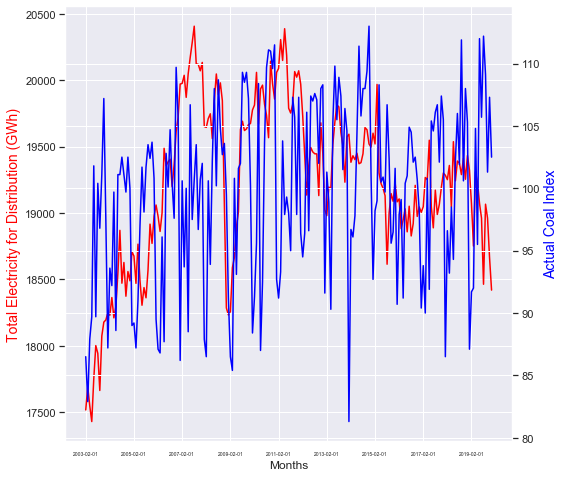

In [26]:
# %matplotlib notebook
fig,ax = plt.subplots(figsize = (8,8))
ax2 = ax.twinx()

ax.plot(power_df.index, power_df['Total Electricity for Distribution (GWh)'], color = 'red')
ax.set_ylabel('Total Electricity for Distribution (GWh)',fontsize = 14, color = 'red')
ax.set_xlabel('Months')

ax2.plot(coal_df.index,coal_df['Actual Coal Index'], color = 'blue')
ax2.set_ylabel('Actual Coal Index',fontsize = 14, color = 'blue')

plt.xticks(np.arange(0,len(power_df.index),24))
ax.tick_params(axis = 'x',labelsize = 5)

sns.set()
plt.show()

In [ ]:
##acf 
#crosscorelation
#Use nonseasonal
#lag plots